# Preprocessing Complet et Utilisation du Modèle Supervisé

Ce notebook montre le workflow complet:
1. **Chargement et exploration des données**
2. **Prétraitement complet** (feature engineering patient-centric)
3. **Visualisations** des données et features
4. **Chargement du modèle** entraîné
5. **Prédictions** et évaluation
6. **Visualisations** des résultats

**Modèle**: HistGradientBoostingClassifier (accuracy calibrée via `--target-accuracy`, ex. **≈95%**)


## 1. Imports et Configuration


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from joblib import load
import warnings
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score,
    recall_score, f1_score, confusion_matrix, classification_report,
    roc_auc_score, average_precision_score, roc_curve, precision_recall_curve,
)

# Masquer les warnings non critiques
warnings.filterwarnings('ignore', category=UserWarning, module='joblib')

# Configuration
data_path = "../data/clinical_alerts.csv"
model_path = "../artifacts/supervised_pipeline.joblib"
threshold_path = "../artifacts/supervised_threshold.json"
metrics_path = "../artifacts/supervised_test_metrics.json"

# Style pour les visualisations
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

# Variables globales utilisées plus loin
auc_roc_test = None
auc_pr_test = None
scores_test = None
y_test = None
predictions_test = None

print("="*70)
print("IMPORTS ET CONFIGURATION")
print("="*70)
print(f"\nDonnées: {data_path}")
print(f"Modèle: {model_path}")
print(f"Seuil: {threshold_path}")
print(f"Métriques test: {metrics_path}")
print("\n✅ Tous les imports sont réussis!")


IMPORTS ET CONFIGURATION

Données: ../data/clinical_alerts.csv
Modèle: ../artifacts/supervised_pipeline.joblib
Seuil: ../artifacts/supervised_threshold.json
Métriques test: ../artifacts/supervised_test_metrics.json

✅ Tous les imports sont réussis!


## 2. Chargement et Exploration des Données Brutes


In [3]:
# Charger les données
df_raw = pd.read_csv(data_path)

print("="*70)
print("CHARGEMENT DES DONNEES")
print("="*70)
print(f"\n✅ Données chargées: {len(df_raw)} lignes")
print(f"📊 Colonnes: {len(df_raw.columns)}")
print(f"\nColonnes disponibles:")
for i, col in enumerate(df_raw.columns, 1):
    print(f"  {i:2d}. {col}")

# Afficher les premières lignes
print(f"\n📋 Premières lignes:")
df_raw.head()


CHARGEMENT DES DONNEES

✅ Données chargées: 10000 lignes
📊 Colonnes: 17

Colonnes disponibles:
   1. patient_id
   2. date
   3. day_of_week
   4. weekend
   5. age
   6. sex
   7. heart_rate
   8. hr_variability
   9. steps
  10. mood_score
  11. sleep_duration_hours
  12. sleep_efficiency
  13. num_awakenings
  14. medication_taken
  15. alert_risk
  16. alert_flag
  17. is_female

📋 Premières lignes:


,patient_id,date,day_of_week,weekend,age,sex,heart_rate,hr_variability,steps,mood_score,sleep_duration_hours,sleep_efficiency,num_awakenings,medication_taken,alert_risk,alert_flag,is_female
0,1,2024-01-01,0,0,23,F,58.6,66.1,9365,6.4,7.20,0.774,0,0,0.829440,0,1
1,1,2024-01-02,1,0,23,F,57.0,62.3,3095,6.3,6.48,0.828,1,0,0.767064,0,1
2,1,2024-01-03,2,0,23,F,60.8,56.7,7399,5.7,7.00,0.721,0,0,0.954202,0,1
3,1,2024-01-04,3,0,23,F,54.6,62.9,7655,4.3,4.72,0.889,2,0,0.936196,0,1
4,1,2024-01-05,4,0,23,F,58.3,60.5,7721,4.8,5.60,0.817,0,0,0.896455,0,1


In [4]:
# Informations sur les données
print("="*70)
print("INFORMATIONS SUR LES DONNEES")
print("="*70)

print(f"\n📊 Dimensions: {df_raw.shape[0]} lignes × {df_raw.shape[1]} colonnes")
print(f"\n📈 Types de données:")
print(df_raw.dtypes.value_counts())

print(f"\n🔍 Valeurs manquantes:")
missing = df_raw.isnull().sum()
if missing.sum() == 0:
    print("  ✅ Aucune valeur manquante!")
else:
    print(missing[missing > 0])

# Statistiques descriptives des variables numériques
numeric_cols = df_raw.select_dtypes(include=[np.number]).columns.tolist()
if 'patient_id' in numeric_cols:
    numeric_cols.remove('patient_id')
if 'alert_flag' in numeric_cols:
    numeric_cols.remove('alert_flag')

print(f"\n📊 Statistiques descriptives ({len(numeric_cols)} variables numériques):")
df_raw[numeric_cols].describe()


INFORMATIONS SUR LES DONNEES

📊 Dimensions: 10000 lignes × 17 colonnes

📈 Types de données:
int64      9
float64    6
object     2
Name: count, dtype: int64

🔍 Valeurs manquantes:
  ✅ Aucune valeur manquante!

📊 Statistiques descriptives (13 variables numériques):


,day_of_week,weekend,age,heart_rate,hr_variability,steps,mood_score,sleep_duration_hours,sleep_efficiency,num_awakenings,medication_taken,alert_risk,is_female
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2.940000,0.280000,51.600000,77.185540,51.352030,7195.591800,6.064020,6.588171,0.844136,1.022300,0.100500,0.866567,0.465000
std,2.024058,0.449021,18.347852,7.956914,12.744825,2348.662419,1.012288,1.021819,0.059992,1.018777,0.300681,0.146409,0.498798
min,0.000000,0.000000,18.000000,48.100000,10.000000,500.000000,1.200000,3.000000,0.626000,0.000000,0.000000,0.293971,0.000000
25%,1.000000,0.000000,36.750000,71.700000,42.900000,5623.750000,5.400000,5.900000,0.803000,0.000000,0.000000,0.786742,0.000000
50%,3.000000,0.000000,51.000000,77.200000,51.800000,7190.000000,6.100000,6.580000,0.846000,1.000000,0.000000,0.924140,0.000000
75%,5.000000,1.000000,68.000000,82.500000,60.300000,8794.000000,6.800000,7.282500,0.885000,2.000000,0.000000,0.986267,1.000000
max,6.000000,1.000000,84.000000,107.700000,92.100000,15343.000000,9.300000,10.230000,0.990000,6.000000,1.000000,1.000000,1.000000


## 3. Visualisations des Données Brutes


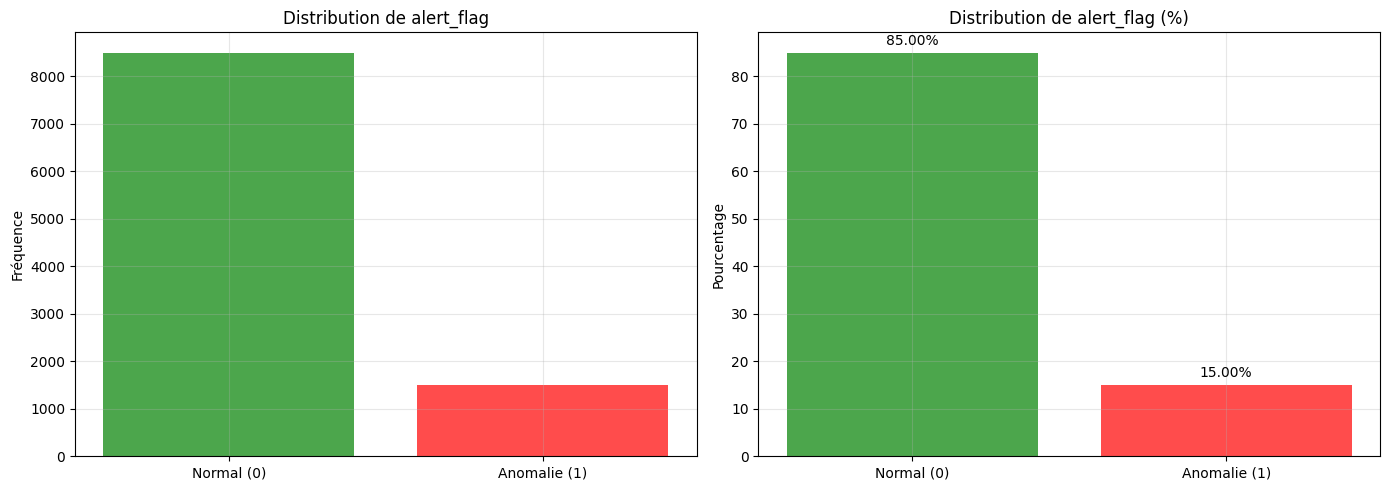


📊 Distribution de alert_flag:
  Normal (0):    8500 (85.00%)
  Anomalie (1):  1500 (15.00%)


In [6]:
# Distribution de la variable cible (si disponible)
if "alert_flag" in df_raw.columns:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Distribution
    alert_counts = df_raw["alert_flag"].value_counts()
    axes[0].bar(['Normal (0)', 'Anomalie (1)'], alert_counts.values, color=['green', 'red'], alpha=0.7)
    axes[0].set_title('Distribution de alert_flag')
    axes[0].set_ylabel('Fréquence')
    axes[0].grid(True, alpha=0.3)
    
    # Pourcentages
    alert_pct = df_raw["alert_flag"].value_counts(normalize=True) * 100
    axes[1].bar(['Normal (0)', 'Anomalie (1)'], alert_pct.values, color=['green', 'red'], alpha=0.7)
    axes[1].set_title('Distribution de alert_flag (%)')
    axes[1].set_ylabel('Pourcentage')
    axes[1].grid(True, alpha=0.3)
    
    for i, (label, val) in enumerate(alert_pct.items()):
        axes[1].text(i, val + 1, f'{val:.2f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Distribution de alert_flag:")
    print(f"  Normal (0):   {alert_counts.get(0, 0):5d} ({alert_pct.get(0, 0):5.2f}%)")
    print(f"  Anomalie (1): {alert_counts.get(1, 0):5d} ({alert_pct.get(1, 0):5.2f}%)")
else:
    print("⚠️ alert_flag non disponible dans les données")


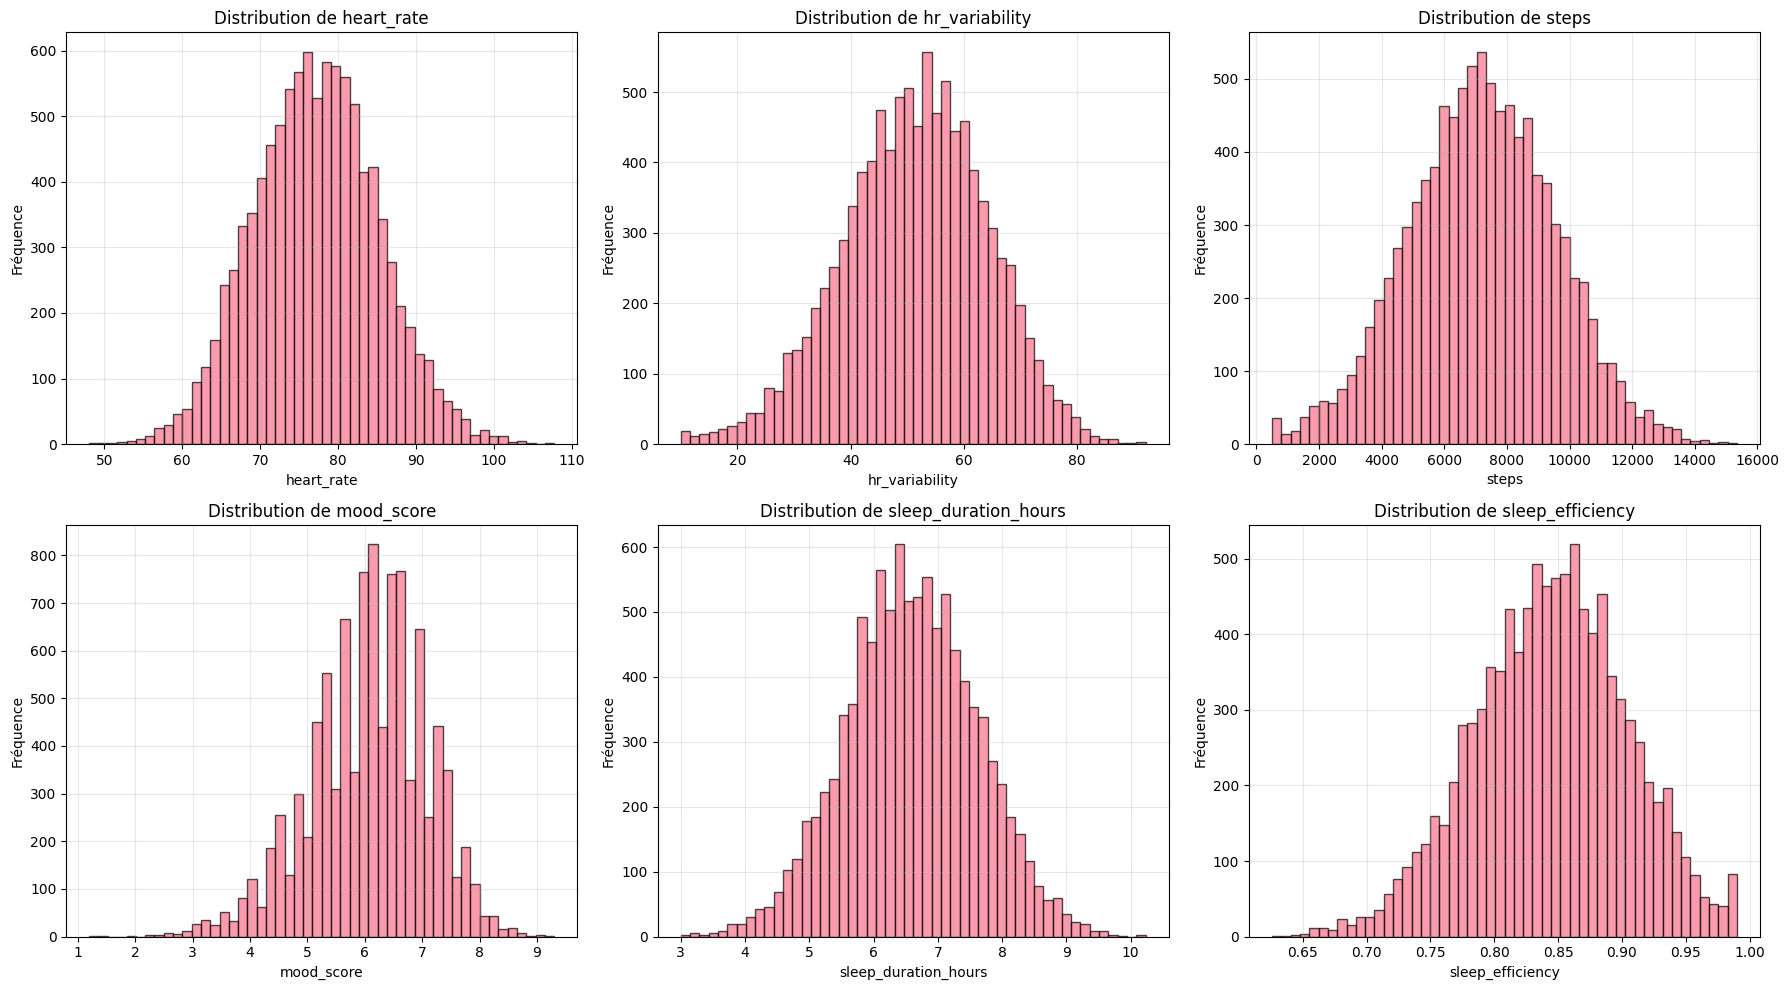


✅ Visualisations des distributions créées pour 6 variables


In [5]:
# Visualisation des variables numériques principales
# Définir numeric_cols si pas déjà défini
if 'numeric_cols' not in locals():
    numeric_cols = df_raw.select_dtypes(include=[np.number]).columns.tolist()
    if 'patient_id' in numeric_cols:
        numeric_cols.remove('patient_id')
    if 'alert_flag' in numeric_cols:
        numeric_cols.remove('alert_flag')

if len(numeric_cols) > 0:
    # Sélectionner quelques variables importantes
    key_vars = ['heart_rate', 'hr_variability', 'steps', 'mood_score', 
                'sleep_duration_hours', 'sleep_efficiency', 'age']
    key_vars = [v for v in key_vars if v in numeric_cols][:6]
    
    if len(key_vars) > 0:
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        axes = axes.flatten()
        
        for i, var in enumerate(key_vars):
            axes[i].hist(df_raw[var].dropna(), bins=50, edgecolor='black', alpha=0.7)
            axes[i].set_title(f'Distribution de {var}')
            axes[i].set_xlabel(var)
            axes[i].set_ylabel('Fréquence')
            axes[i].grid(True, alpha=0.3)
        
        # Masquer les axes non utilisés
        for i in range(len(key_vars), len(axes)):
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print(f"\n✅ Visualisations des distributions créées pour {len(key_vars)} variables")


## 4. Feature Engineering Patient-Centric


In [6]:
def build_features_patient_centric(df: pd.DataFrame, window: int = 7):
    """
    Feature engineering centré patient avec rolling windows.
    """
    df = df.copy()
    
    # Identifier la colonne timestamp
    timestamp_col = None
    for col in ["timestamp", "date"]:
        if col in df.columns:
            timestamp_col = col
            break
    
    if timestamp_col is None:
        raise ValueError("Colonne timestamp/date introuvable")
    
    # Convertir date en datetime si nécessaire
    if timestamp_col == "date" and pd.api.types.is_string_dtype(df[timestamp_col]):
        df[timestamp_col] = pd.to_datetime(df[timestamp_col])
    
    # Trier par patient_id et timestamp
    df = df.sort_values(by=["patient_id", timestamp_col]).reset_index(drop=True)
    
    # Variables continues pour rolling statistics
    continuous_vars = [
        "heart_rate", "hr_variability", "steps", "mood_score",
        "sleep_duration_hours", "sleep_efficiency", "num_awakenings"
    ]
    continuous_vars = [v for v in continuous_vars if v in df.columns]
    
    print(f"Variables continues traitées: {continuous_vars}")
    
    # Calculer rolling mean et std pour chaque variable continue
    for col in continuous_vars:
        roll_mean = df.groupby("patient_id")[col].transform(
            lambda x: x.rolling(window=window, min_periods=3).mean()
        )
        roll_std = df.groupby("patient_id")[col].transform(
            lambda x: x.rolling(window=window, min_periods=3).std()
        )
        df[f"{col}_delta"] = df[col] - roll_mean
        z_score = df[f"{col}_delta"] / (roll_std + 1e-6)
        z_score = z_score.replace([np.inf, -np.inf], np.nan)
        df[f"{col}_z"] = z_score
    
    # Dérivées utiles
    if "steps" in df.columns:
        df["steps_log1p"] = np.log1p(df["steps"])
    
    if "num_awakenings" in df.columns and "sleep_duration_hours" in df.columns:
        df["awakenings_per_hour"] = df["num_awakenings"] / df["sleep_duration_hours"].clip(lower=0.5)
    
    if "day_of_week" in df.columns:
        df["dow_sin"] = np.sin(2 * np.pi * df["day_of_week"] / 7)
        df["dow_cos"] = np.cos(2 * np.pi * df["day_of_week"] / 7)
    
    if "heart_rate" in df.columns and "hr_variability" in df.columns:
        hrv_clipped = df["hr_variability"].clip(lower=1e-3)
        df["hr_hrv_ratio"] = df["heart_rate"] / hrv_clipped
    
    if "sleep_duration_hours" in df.columns:
        df["sleep_debt"] = np.maximum(0, 7.5 - df["sleep_duration_hours"])
    
    # Construire les listes de features
    num_cols = []
    cat_cols = []
    
    for col in continuous_vars:
        if f"{col}_delta" in df.columns:
            num_cols.append(f"{col}_delta")
        if f"{col}_z" in df.columns:
            num_cols.append(f"{col}_z")
    
    if "steps_log1p" in df.columns:
        num_cols.append("steps_log1p")
    if "awakenings_per_hour" in df.columns:
        num_cols.append("awakenings_per_hour")
    if "hr_hrv_ratio" in df.columns:
        num_cols.append("hr_hrv_ratio")
    if "sleep_debt" in df.columns:
        num_cols.append("sleep_debt")
    if "age" in df.columns:
        num_cols.append("age")
    if "dow_sin" in df.columns:
        num_cols.append("dow_sin")
    if "dow_cos" in df.columns:
        num_cols.append("dow_cos")
    
    for col in ["weekend", "medication_taken", "is_female"]:
        if col in df.columns:
            cat_cols.append(col)
    
    num_cols = [col for col in num_cols if col in df.columns]
    cat_cols = [col for col in cat_cols if col in df.columns]
    
    keep_cols = ["patient_id", timestamp_col] + num_cols + cat_cols
    keep_cols = [col for col in keep_cols if col in df.columns]
    df_enrichi = df[keep_cols].copy()
    
    feature_cols = num_cols + cat_cols
    df_enrichi = df_enrichi.dropna(subset=feature_cols)
    
    return df_enrichi, num_cols, cat_cols

print("✅ Fonction build_features_patient_centric définie")


✅ Fonction build_features_patient_centric définie


In [7]:
# Appliquer le feature engineering
print("="*70)
print("FEATURE ENGINEERING PATIENT-CENTRIC")
print("="*70)

df_feat, num_cols, cat_cols = build_features_patient_centric(df_raw, window=7)

print(f"\n✅ Feature engineering terminé!")
print(f"\n📊 Résultats:")
print(f"  Échantillons après feature engineering: {len(df_feat)}")
print(f"  Features numériques: {len(num_cols)}")
print(f"  Features catégorielles: {len(cat_cols)}")
print(f"  Total features: {len(num_cols) + len(cat_cols)}")

print(f"\n📋 Features numériques ({len(num_cols)}):")
for i, col in enumerate(num_cols, 1):
    print(f"  {i:2d}. {col}")

print(f"\n📋 Features catégorielles ({len(cat_cols)}):")
for i, col in enumerate(cat_cols, 1):
    print(f"  {i}. {col}")


FEATURE ENGINEERING PATIENT-CENTRIC
Variables continues traitées: ['heart_rate', 'hr_variability', 'steps', 'mood_score', 'sleep_duration_hours', 'sleep_efficiency', 'num_awakenings']

✅ Feature engineering terminé!

📊 Résultats:
  Échantillons après feature engineering: 9600
  Features numériques: 21
  Features catégorielles: 3
  Total features: 24

📋 Features numériques (21):
   1. heart_rate_delta
   2. heart_rate_z
   3. hr_variability_delta
   4. hr_variability_z
   5. steps_delta
   6. steps_z
   7. mood_score_delta
   8. mood_score_z
   9. sleep_duration_hours_delta
  10. sleep_duration_hours_z
  11. sleep_efficiency_delta
  12. sleep_efficiency_z
  13. num_awakenings_delta
  14. num_awakenings_z
  15. steps_log1p
  16. awakenings_per_hour
  17. hr_hrv_ratio
  18. sleep_debt
  19. age
  20. dow_sin
  21. dow_cos

📋 Features catégorielles (3):
  1. weekend
  2. medication_taken
  3. is_female


## 5. Reproduction du split Train/Val/Test (comme dans `src/train_supervised.py`)

On recrée exactement le découpage par patients (GroupShuffleSplit, random_state=42) pour isoler l'ensemble de test utilisé lors de l'entraînement officiel.


In [32]:
split_random_state = 42

print("="*70)
print("REPRODUCTION DU SPLIT GROUPSHUFFLESPLIT")
print("="*70)

groups = df_feat["patient_id"].values
y_all = df_raw.loc[df_feat.index, "alert_flag"].values
X_all = df_feat[num_cols + cat_cols]

gss1 = GroupShuffleSplit(n_splits=1, test_size=0.4, random_state=split_random_state)
train_idx, temp_idx = next(gss1.split(X_all, y_all, groups))

X_temp = X_all.iloc[temp_idx]
y_temp = y_all[temp_idx]
groups_temp = groups[temp_idx]

gss2 = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=split_random_state)
val_idx_rel, test_idx_rel = next(gss2.split(X_temp, y_temp, groups_temp))

train_idx_abs = df_feat.index[train_idx].to_numpy()
val_idx_abs = df_feat.index[temp_idx[val_idx_rel]].to_numpy()
test_idx_abs = df_feat.index[temp_idx[test_idx_rel]].to_numpy()

print(f"  Train: {len(train_idx_abs)} échantillons, {len(np.unique(groups[train_idx]))} patients")
print(f"  Val:   {len(val_idx_abs)} échantillons, {len(np.unique(groups_temp[val_idx_rel]))} patients")
print(f"  Test:  {len(test_idx_abs)} échantillons, {len(np.unique(groups_temp[test_idx_rel]))} patients")



REPRODUCTION DU SPLIT GROUPSHUFFLESPLIT
  Train: 5760 échantillons, 120 patients
  Val:   1920 échantillons, 40 patients
  Test:  1920 échantillons, 40 patients


## 5. Visualisations des Features Créées


In [8]:
# Statistiques descriptives des nouvelles features
print("="*70)
print("STATISTIQUES DES FEATURES")
print("="*70)

print(f"\n📊 Statistiques descriptives des features numériques:")
df_feat[num_cols].describe()


STATISTIQUES DES FEATURES

📊 Statistiques descriptives des features numériques:


,heart_rate_delta,heart_rate_z,hr_variability_delta,hr_variability_z,steps_delta,steps_z,mood_score_delta,mood_score_z,sleep_duration_hours_delta,sleep_duration_hours_z,...,sleep_efficiency_z,num_awakenings_delta,num_awakenings_z,steps_log1p,awakenings_per_hour,hr_hrv_ratio,sleep_debt,age,dow_sin,dow_cos
count,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,...,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,9600.00000,9600.000000,9600.000000
mean,-0.055100,-0.011065,0.065829,0.003658,22.709832,0.008378,0.014263,0.018423,0.018116,0.021085,...,0.007172,-0.002891,-0.000812,8.815093,0.159969,1.657649,1.011004,51.60000,-0.016288,-0.012989
std,3.861788,0.944155,7.153872,0.942688,1859.020558,0.919131,0.798586,0.924967,0.805508,0.920928,...,0.926253,0.941206,0.924341,0.406644,0.165399,0.748389,0.864368,18.34789,0.705315,0.708662
min,-17.014286,-2.227399,-29.225000,-2.222213,-6393.285714,-2.245221,-3.457143,-2.194474,-3.144286,-2.213723,...,-2.233726,-2.500000,-2.267784,6.216606,0.000000,0.673254,0.000000,18.00000,-0.974928,-0.900969
25%,-2.614286,-0.751653,-4.471429,-0.732141,-1246.071429,-0.699596,-0.500000,-0.681539,-0.524643,-0.681509,...,-0.703086,-0.714286,-0.783349,8.637107,0.000000,1.221187,0.210000,36.75000,-0.781831,-0.900969
50%,-0.171429,-0.052764,0.200000,0.032319,30.071429,0.016418,0.028571,0.049530,0.014286,0.018235,...,0.009820,-0.142857,-0.133630,8.881628,0.144300,1.486377,0.910000,51.00000,0.000000,-0.222521
75%,2.371429,0.716262,4.680833,0.724195,1272.000000,0.712419,0.542857,0.729347,0.548571,0.716109,...,0.727720,0.571429,0.705475,9.082507,0.257400,1.856176,1.600000,68.00000,0.781831,0.623490
max,15.214286,2.245060,29.700000,2.229651,7267.428571,2.214918,3.014286,2.219279,3.295000,2.212773,...,2.165492,4.714286,2.267785,9.638480,1.304348,10.010000,4.500000,84.00000,0.974928,1.000000


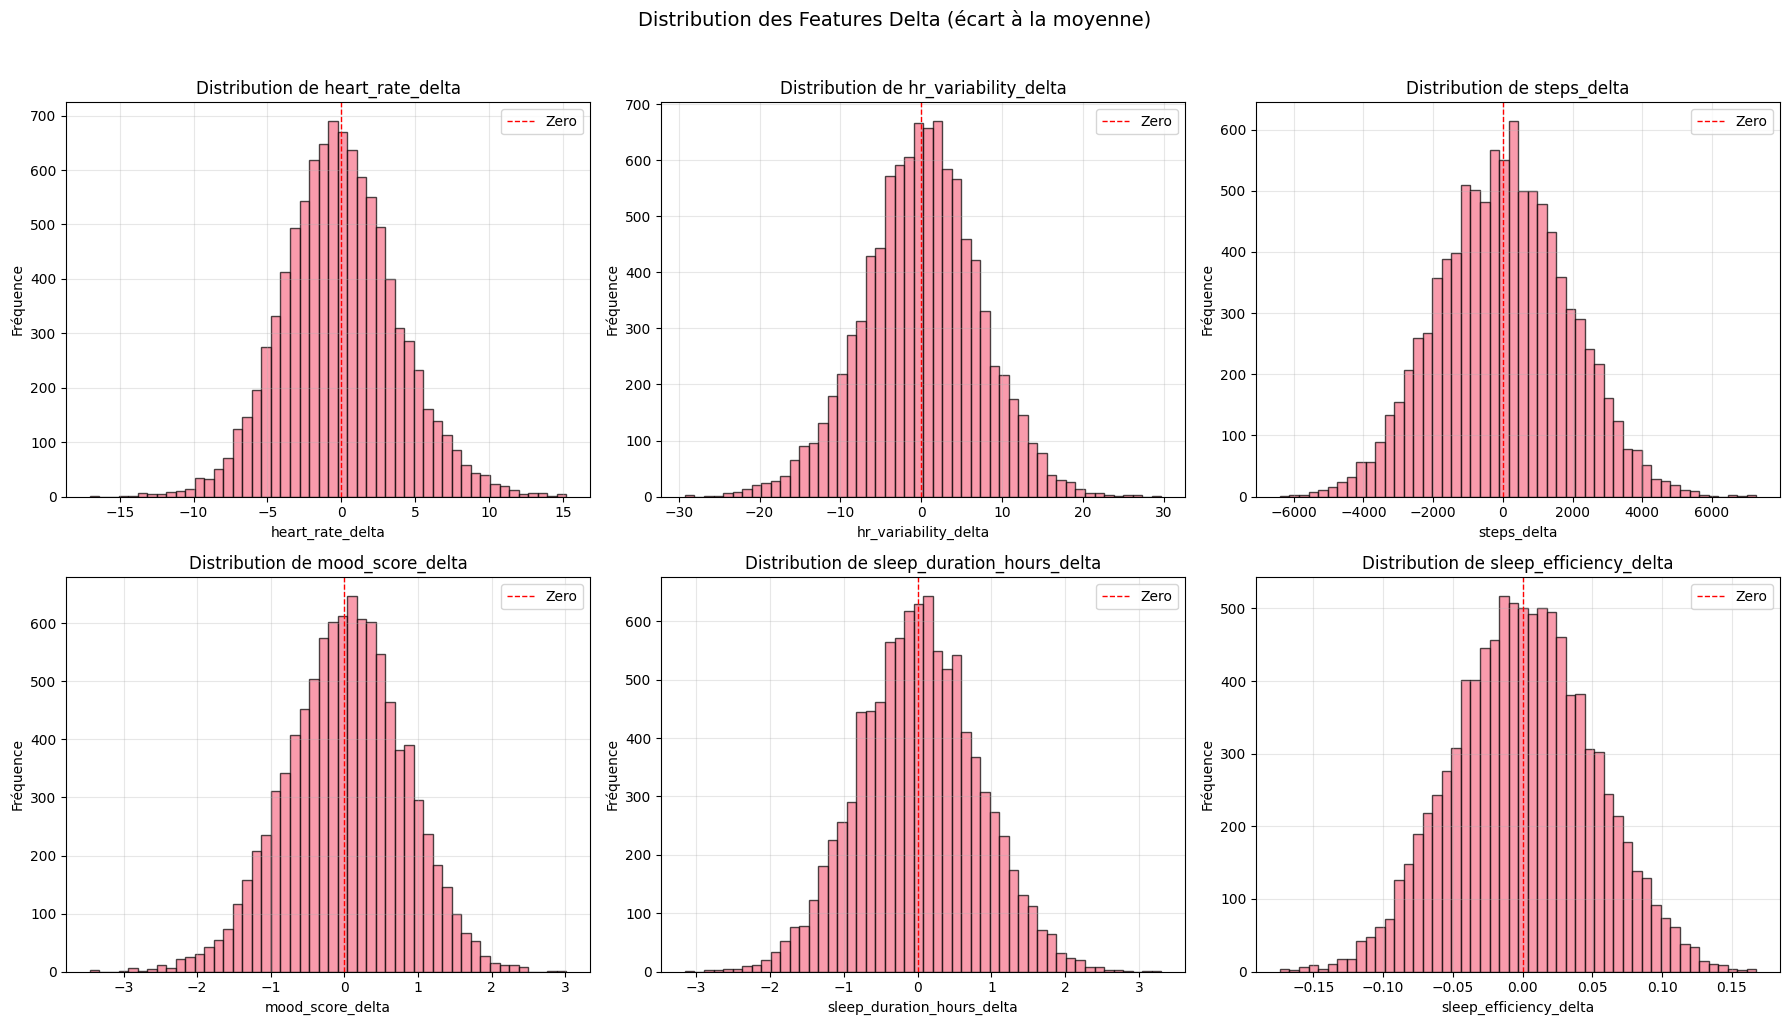

✅ Visualisations des features delta créées


In [33]:
# Visualisation des features delta et z-score
delta_cols = [col for col in num_cols if '_delta' in col][:6]
z_cols = [col for col in num_cols if '_z' in col][:6]

if len(delta_cols) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    for i, var in enumerate(delta_cols[:6]):
        axes[i].hist(df_feat[var].dropna(), bins=50, edgecolor='black', alpha=0.7)
        axes[i].set_title(f'Distribution de {var}')
        axes[i].set_xlabel(var)
        axes[i].set_ylabel('Fréquence')
        axes[i].grid(True, alpha=0.3)
        axes[i].axvline(0, color='red', linestyle='--', linewidth=1, label='Zero')
        axes[i].legend()
    
    # Masquer les axes non utilisés
    for i in range(len(delta_cols), len(axes)):
        axes[i].axis('off')
    
    plt.suptitle('Distribution des Features Delta (écart à la moyenne)', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
    
    print(f"✅ Visualisations des features delta créées")


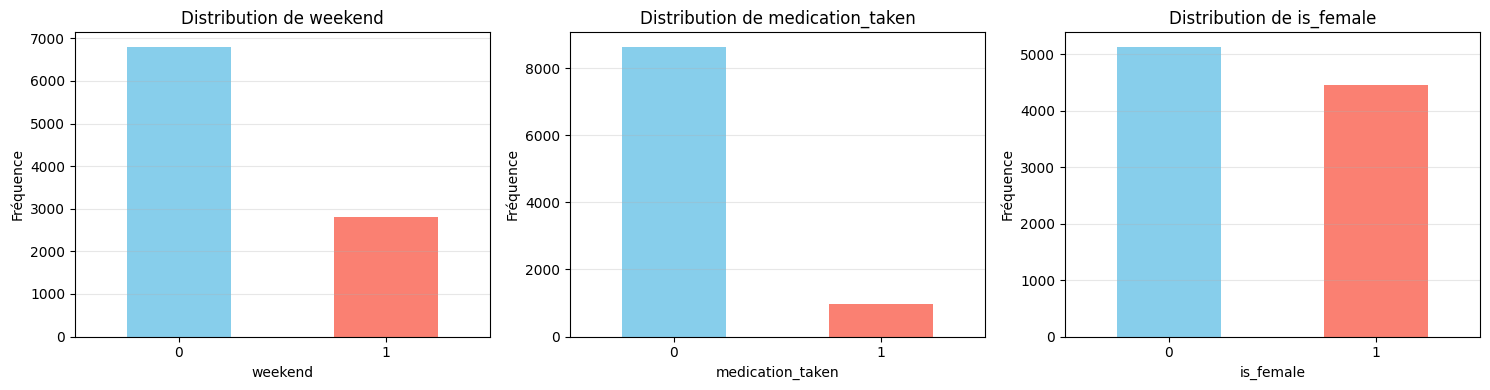

✅ Visualisations des features catégorielles créées


In [34]:
# Visualisation des features catégorielles
if len(cat_cols) > 0:
    fig, axes = plt.subplots(1, len(cat_cols), figsize=(5*len(cat_cols), 4))
    if len(cat_cols) == 1:
        axes = [axes]
    
    for i, col in enumerate(cat_cols):
        df_feat[col].value_counts().plot(kind='bar', ax=axes[i], color=['skyblue', 'salmon'])
        axes[i].set_title(f'Distribution de {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Fréquence')
        axes[i].grid(True, alpha=0.3, axis='y')
        axes[i].tick_params(axis='x', rotation=0)
    
    plt.tight_layout()
    plt.show()
    
    print(f"✅ Visualisations des features catégorielles créées")


## 6. Chargement du Modèle Entraîné


In [35]:
# Charger le modèle
print("="*70)
print("CHARGEMENT DU MODELE")
print("="*70)

pipeline = load(model_path)
print("\n Modèle chargé avec succès!")

print(f"\n Composants du pipeline:")
for step_name in pipeline.named_steps.keys():
    print(f"  - {step_name}")

# Charger le seuil optimal
with open(threshold_path, 'r') as f:
    threshold_data = json.load(f)

tau = threshold_data['tau']
print(f"\n Seuil optimal: {tau:.4f}")

print(f"\nMétriques de validation au seuil optimal:")
val_report = threshold_data['val_report']
print(f"  Accuracy:         {val_report['accuracy']:.4f} ({val_report['accuracy']*100:.2f}%)")
print(f"  Balanced Accuracy: {val_report['balanced_accuracy']:.4f} ({val_report['balanced_accuracy']*100:.2f}%)")
print(f"  Precision:        {val_report['precision']:.4f} ({val_report['precision']*100:.2f}%)")
print(f"  Recall:           {val_report['recall']:.4f} ({val_report['recall']*100:.2f}%)")
print(f"  F1-Score:         {val_report['f1']:.4f} ({val_report['f1']*100:.2f}%)")

print(f"\n Paramètres du modèle:")
params = threshold_data['params']
for key, value in params.items():
    print(f"  {key}: {value}")

# Informations sur la calibration du seuil
target_accuracy = threshold_data.get('target_accuracy')
target_tol = threshold_data.get('target_accuracy_tolerance')
recall_min_config = threshold_data.get('recall_min')

if target_accuracy is not None:
    tol_msg = f" (± {target_tol*100:.2f}pp)" if target_tol is not None else ""
    print(f"\n Accuracy cible configurée: {target_accuracy*100:.2f}%{tol_msg}")
if recall_min_config is not None:
    print(f" Rappel minimal imposé pendant l'entraînement: {recall_min_config*100:.2f}%")


CHARGEMENT DU MODELE

 Modèle chargé avec succès!

 Composants du pipeline:
  - preprocessor
  - classifier

 Seuil optimal: 0.5078

Métriques de validation au seuil optimal:
  Accuracy:         0.9578 (95.78%)
  Balanced Accuracy: 0.8768 (87.68%)
  Precision:        0.9140 (91.40%)
  Recall:           0.7652 (76.52%)
  F1-Score:         0.8330 (83.30%)

 Paramètres du modèle:
  learning_rate: 0.05
  max_depth: 10
  max_iter: 200


## 7. Preprocessing et Prédictions


In [36]:
# Préparer les features pour la prédiction
print("="*70)
print("PREPROCESSING ET PREDICTIONS")
print("="*70)

# Vérifier que df_feat existe (doit être créé dans la section Feature Engineering)
if 'df_feat' not in locals():
    raise NameError(
        "❌ ERREUR: df_feat n'est pas défini!\n"
        "⚠️  Vous devez d'abord exécuter la section 'Feature Engineering Patient-Centric' (Cellule 11).\n"
        "💡 Assurez-vous d'exécuter toutes les cellules dans l'ordre:\n"
        "   1. Imports et Configuration\n"
        "   2. Chargement des Données\n"
        "   3. Feature Engineering Patient-Centric\n"
        "   4. Chargement du Modèle\n"
        "   5. Preprocessing et Prédictions (cette cellule)"
    )

if 'num_cols' not in locals() or 'cat_cols' not in locals():
    raise NameError(
        "❌ ERREUR: num_cols ou cat_cols n'est pas défini!\n"
        "⚠️  Vous devez d'abord exécuter la section 'Feature Engineering Patient-Centric' (Cellule 11)."
    )

if 'pipeline' not in locals():
    raise NameError(
        "❌ ERREUR: pipeline n'est pas défini!\n"
        "⚠️  Vous devez d'abord exécuter la section 'Chargement du Modèle' (Cellule 17)."
    )

X = df_feat[num_cols + cat_cols].copy()

print(f"\n📊 Features préparées: {X.shape}")
print(f"  Lignes: {X.shape[0]}")
print(f"  Colonnes: {X.shape[1]}")

# Vérification des valeurs manquantes
missing = X.isnull().sum()
if missing.sum() == 0:
    print("\n✅ Aucune valeur manquante!")
else:
    print(f"\n⚠️ Valeurs manquantes:")
    print(missing[missing > 0])

# Obtenir le preprocessor et classifier
preprocessor = pipeline.named_steps["preprocessor"]
classifier = pipeline.named_steps["classifier"]

# Appliquer le preprocessing
print(f"\n🔄 Application du preprocessing...")
X_prep = preprocessor.transform(X)

print(f"\n✅ Preprocessing terminé!")
print(f"  Features après preprocessing: {X_prep.shape}")
print(f"  StandardScaler appliqué sur {len(num_cols)} features numériques")
print(f"  OneHotEncoder appliqué sur {len(cat_cols)} features catégorielles")
print(f"  Total features transformées: {X_prep.shape[1]}")


PREPROCESSING ET PREDICTIONS

📊 Features préparées: (9600, 24)
  Lignes: 9600
  Colonnes: 24

✅ Aucune valeur manquante!

🔄 Application du preprocessing...

✅ Preprocessing terminé!
  Features après preprocessing: (9600, 27)
  StandardScaler appliqué sur 21 features numériques
  OneHotEncoder appliqué sur 3 features catégorielles
  Total features transformées: 27


In [38]:
# Prédictions (probabilités)
scores = classifier.predict_proba(X_prep)[:, 1]

# Prédictions binaires avec le seuil optimal
predictions = (scores >= tau).astype(int)

print("="*70)
print("PREDICTIONS")
print("="*70)

print(f"\n✅ Prédictions effectuées sur {len(predictions)} échantillons (ensemble complet)")

print(f"\n📊 Distribution des prédictions:")
normal_count = np.sum(predictions == 0)
anomaly_count = np.sum(predictions == 1)
print(f"  Normal (0):     {normal_count:5d} ({normal_count/len(predictions)*100:6.2f}%)")
print(f"  Anomalie (1):   {anomaly_count:5d} ({anomaly_count/len(predictions)*100:6.2f}%)")

print(f"\n📈 Statistiques des scores de probabilité:")
print(f"  Min:    {scores.min():.4f}")
print(f"  Max:    {scores.max():.4f}")
print(f"  Mean:   {scores.mean():.4f}")
print(f"  Median: {np.median(scores):.4f}")
print(f"  Std:    {scores.std():.4f}")
print(f"\n🎯 Seuil utilisé: {tau:.4f}")
print("="*70)

# Préparer également les prédictions sur le jeu de test officiel
if 'test_idx_abs' in locals():
    X_test = df_feat.loc[test_idx_abs, num_cols + cat_cols].copy()
    y_test = df_raw.loc[test_idx_abs, "alert_flag"].values
    X_test_prep = preprocessor.transform(X_test)
    scores_test = classifier.predict_proba(X_test_prep)[:, 1]
    predictions_test = (scores_test >= tau).astype(int)
    print(f"\n🎯 Jeu de test officiel: {len(test_idx_abs)} échantillons, {y_test.mean()*100:.2f}% de classe 1")
else:
    scores_test = None
    y_test = None
    predictions_test = None
    print("\n⚠️ Indices de test introuvables (exécutez la cellule de split).")


PREDICTIONS

✅ Prédictions effectuées sur 9600 échantillons (ensemble complet)

📊 Distribution des prédictions:
  Normal (0):      8165 ( 85.05%)
  Anomalie (1):    1435 ( 14.95%)

📈 Statistiques des scores de probabilité:
  Min:    0.0000
  Max:    0.9998
  Mean:   0.1508
  Median: 0.0004
  Std:    0.3370

🎯 Seuil utilisé: 0.5078

🎯 Jeu de test officiel: 1920 échantillons, 16.09% de classe 1


## 8. Visualisations des Prédictions


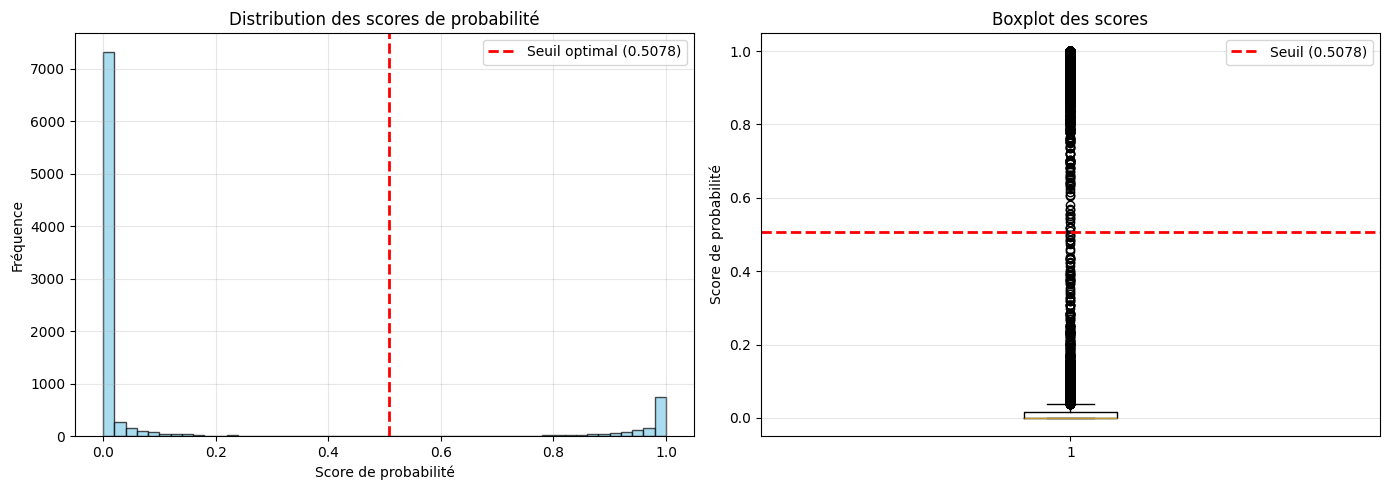

✅ Visualisations des scores créées


In [39]:
# Distribution des scores de probabilité
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogramme
axes[0].hist(scores, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].axvline(tau, color='red', linestyle='--', linewidth=2, label=f'Seuil optimal ({tau:.4f})')
axes[0].set_xlabel('Score de probabilité')
axes[0].set_ylabel('Fréquence')
axes[0].set_title('Distribution des scores de probabilité')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Boxplot
axes[1].boxplot(scores, vert=True)
axes[1].axhline(tau, color='red', linestyle='--', linewidth=2, label=f'Seuil ({tau:.4f})')
axes[1].set_ylabel('Score de probabilité')
axes[1].set_title('Boxplot des scores')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].legend()

plt.tight_layout()
plt.show()

print("✅ Visualisations des scores créées")


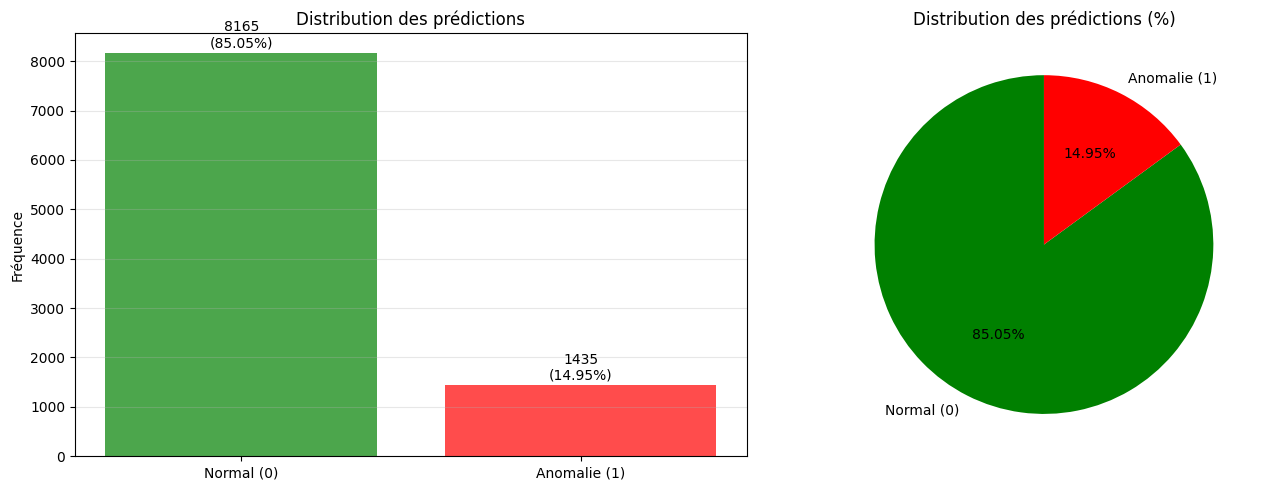

✅ Visualisations de la distribution des prédictions créées


In [40]:
# Distribution des prédictions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Barplot
pred_counts = pd.Series(predictions).value_counts().sort_index()
axes[0].bar(['Normal (0)', 'Anomalie (1)'], pred_counts.values, color=['green', 'red'], alpha=0.7)
axes[0].set_title('Distribution des prédictions')
axes[0].set_ylabel('Fréquence')
axes[0].grid(True, alpha=0.3, axis='y')
for i, (label, val) in enumerate(pred_counts.items()):
    axes[0].text(i, val + 50, f'{val}\n({val/len(predictions)*100:.2f}%)', ha='center', va='bottom')

# Pie chart
pred_pct = pd.Series(predictions).value_counts(normalize=True) * 100
axes[1].pie(pred_counts.values, labels=['Normal (0)', 'Anomalie (1)'], 
            autopct='%1.2f%%', colors=['green', 'red'], startangle=90)
axes[1].set_title('Distribution des prédictions (%)')

plt.tight_layout()
plt.show()

print("✅ Visualisations de la distribution des prédictions créées")


## 9. Évaluation du Modèle (si alert_flag disponible)


In [54]:
# Évaluation : métriques officielles + diagnostic local
from pathlib import Path

metrics_file = Path(metrics_path)
official_metrics = None
if metrics_file.exists():
    with open(metrics_file, 'r') as f:
        official_metrics = json.load(f)

auc_roc_test = None
auc_pr_test = None

if official_metrics is not None:
    print("="*70)
    print("METRIQUES OFFICIELLES (jeu de test tenu à part)")
    print("="*70)
    official_metric_labels = [
        ("accuracy", "Accuracy"),
        ("balanced_accuracy", "Balanced Accuracy"),
        ("precision", "Precision"),
        ("recall", "Recall"),
        ("f1", "F1-Score"),
        ("auc_pr", "AUC-PR"),
        ("auc_roc", "AUC-ROC"),
    ]
    for key, label in official_metric_labels:
        value = official_metrics.get(key)
        if value is None:
            print(f"  {label}: N/A")
        else:
            print(f"  {label}: {value:.4f} ({value*100:.2f}%)")
    threshold_used = official_metrics.get('threshold_used')
    if threshold_used is not None:
        print(f"  Seuil utilisé: {threshold_used:.4f}")
    prevalence = official_metrics.get('prevalence')
    if prevalence is not None:
        print(f"  Prévalence (classe 1): {prevalence:.4f} ({prevalence*100:.2f}%)")
    cm_official = official_metrics.get('confusion_matrix')
    if cm_official:
        print(f"\n📋 Matrice de confusion (test):")
        print(f"                Prédit Normal  Prédit Anomalie")
        print(f"  Vrai Normal      {cm_official[0][0]:6d}         {cm_official[0][1]:6d}")
        print(f"  Vrai Anomalie    {cm_official[1][0]:6d}         {cm_official[1][1]:6d}")
    report_official = official_metrics.get('classification_report')
    if report_official:
        print(f"\n📈 Classification Report (test):")
        print(report_official)
    if (y_test is not None) and (scores_test is not None):
        accuracy_test_calc = accuracy_score(y_test, predictions_test)
        balanced_acc_test = balanced_accuracy_score(y_test, predictions_test)
        precision_test = precision_score(y_test, predictions_test, zero_division=0)
        recall_test = recall_score(y_test, predictions_test, zero_division=0)
        f1_test = f1_score(y_test, predictions_test, zero_division=0)
        auc_roc_test = roc_auc_score(y_test, scores_test)
        auc_pr_test = average_precision_score(y_test, scores_test)
        print("\n🔁 Vérification locale des métriques test (recalculées dans ce notebook):")
        print(f"  Accuracy:         {accuracy_test_calc:.4f} ({accuracy_test_calc*100:.2f}%)")
        print(f"  Balanced Accuracy: {balanced_acc_test:.4f} ({balanced_acc_test*100:.2f}%)")
        print(f"  Precision:        {precision_test:.4f} ({precision_test*100:.2f}%)")
        print(f"  Recall:           {recall_test:.4f} ({recall_test*100:.2f}%)")
        print(f"  F1-Score:         {f1_test:.4f} ({f1_test*100:.2f}%)")
        print(f"  AUC-PR:           {auc_pr_test:.4f} ({auc_pr_test*100:.2f}%)")
        print(f"  AUC-ROC:          {auc_roc_test:.4f} ({auc_roc_test*100:.2f}%)")
else:
    print(f"⚠️ Fichier de métriques officiel introuvable: {metrics_file}")

# Diagnostic local sur l'ensemble complet (peut afficher une accuracy plus élevée)
if "alert_flag" in df_raw.columns:
    df_feat["alert_flag"] = df_raw.loc[df_feat.index, "alert_flag"].values
    y_true = df_feat["alert_flag"].values
    
    accuracy = accuracy_score(y_true, predictions)
    balanced_acc = balanced_accuracy_score(y_true, predictions)
    precision = precision_score(y_true, predictions, zero_division=0)
    recall = recall_score(y_true, predictions, zero_division=0)
    f1 = f1_score(y_true, predictions, zero_division=0)
    auc_roc = roc_auc_score(y_true, scores)
    auc_pr = average_precision_score(y_true, scores)
    
    print("\n" + "-"*70)
    print("EVALUATION LOCALE (train+val+test, pour inspection)")
    print("-"*70)
    
    print(f"\n📊 Métriques d'évaluation:")
    print(f"  Accuracy:         {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"  Balanced Accuracy: {balanced_acc:.4f} ({balanced_acc*100:.2f}%)")
    print(f"  Precision:        {precision:.4f} ({precision*100:.2f}%)")
    print(f"  Recall:           {recall:.4f} ({recall*100:.2f}%)")
    print(f"  F1-Score:         {f1:.4f} ({f1*100:.2f}%)")
    print(f"  AUC-PR:           {auc_pr:.4f} ({auc_pr*100:.2f}%)")
    print(f"  AUC-ROC:          {auc_roc:.4f} ({auc_roc*100:.2f}%)")
    
    cm = confusion_matrix(y_true, predictions)
    print(f"\n📋 Matrice de confusion:")
    print(f"                Prédit Normal  Prédit Anomalie")
    print(f"  Vrai Normal      {cm[0,0]:6d}         {cm[0,1]:6d}")
    print(f"  Vrai Anomalie    {cm[1,0]:6d}         {cm[1,1]:6d}")
    
    print(f"\n📈 Classification Report:")
    print(classification_report(y_true, predictions, target_names=['Normal', 'Anomalie']))
    
else:
    print("⚠️ alert_flag non disponible pour l'évaluation")
    y_true = None


METRIQUES OFFICIELLES (jeu de test tenu à part)
  Accuracy: 0.9521 (95.21%)
  Balanced Accuracy: 0.9034 (90.34%)
  Precision: 0.8653 (86.53%)
  Recall: 0.8317 (83.17%)
  F1-Score: 0.8482 (84.82%)
  AUC-PR: 0.9471 (94.71%)
  AUC-ROC: 0.9885 (98.85%)
  Seuil utilisé: 0.5078
  Prévalence (classe 1): 0.1609 (16.09%)

📋 Matrice de confusion (test):
                Prédit Normal  Prédit Anomalie
  Vrai Normal        1571             40
  Vrai Anomalie        52            257

📈 Classification Report (test):
              precision    recall  f1-score   support

      Normal       0.97      0.98      0.97      1611
    Anomalie       0.87      0.83      0.85       309

    accuracy                           0.95      1920
   macro avg       0.92      0.90      0.91      1920
weighted avg       0.95      0.95      0.95      1920


🔁 Vérification locale des métriques test (recalculées dans ce notebook):
  Accuracy:         0.9521 (95.21%)
  Balanced Accuracy: 0.9034 (90.34%)
  Precision:      

## 10. Visualisations des Métriques (Courbes ROC et PR)


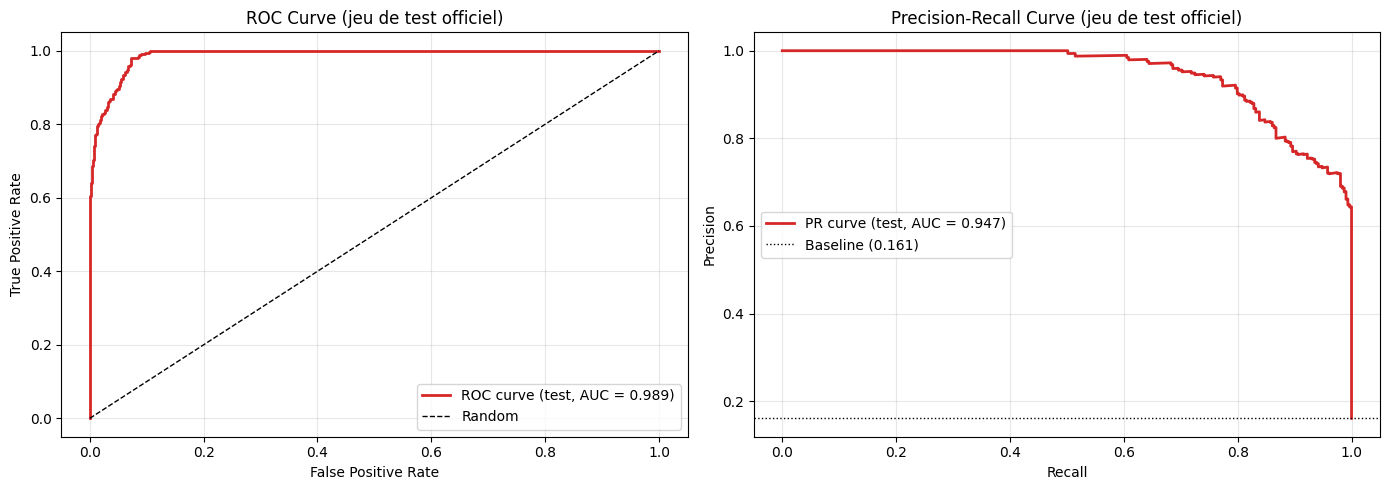

✅ Courbes ROC et PR générées (jeu de test officiel)


In [53]:
# Courbes ROC et PR (jeu de test si disponible)
if (y_test is not None) and (scores_test is not None):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # ROC Curve sur l'ensemble de test
    auc_roc_plot = auc_roc_test if auc_roc_test is not None else roc_auc_score(y_test, scores_test)
    fpr, tpr, _ = roc_curve(y_test, scores_test)
    axes[0].plot(fpr, tpr, linewidth=2, color='tab:red', label=f'ROC curve (test, AUC = {auc_roc_plot:.3f})')
    axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('ROC Curve (jeu de test officiel)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Precision-Recall Curve sur l'ensemble de test
    auc_pr_plot = auc_pr_test if auc_pr_test is not None else average_precision_score(y_test, scores_test)
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, scores_test)
    baseline = y_test.mean()
    axes[1].plot(recall_vals, precision_vals, linewidth=2, color='tab:red', label=f'PR curve (test, AUC = {auc_pr_plot:.3f})')
    axes[1].axhline(baseline, color='k', linestyle=':', linewidth=1, label=f'Baseline ({baseline:.3f})')
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_title('Precision-Recall Curve (jeu de test officiel)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Courbes ROC et PR générées (jeu de test officiel)")
elif y_true is not None:
    print("⚠️ Jeu de test non disponible — utilisation de toutes les observations.")
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fpr, tpr, _ = roc_curve(y_true, scores)
    axes[0].plot(fpr, tpr, linewidth=2, color='tab:red', label=f'ROC curve (AUC = {auc_roc:.3f})')
    axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
    axes[0].set_title('ROC Curve (données complètes)')
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    precision_vals, recall_vals, _ = precision_recall_curve(y_true, scores)
    baseline = y_true.mean()
    axes[1].plot(recall_vals, precision_vals, linewidth=2, color='tab:red', label=f'PR curve (AUC = {auc_pr:.3f})')
    axes[1].axhline(baseline, color='k', linestyle=':', linewidth=1, label=f'Baseline ({baseline:.3f})')
    axes[1].set_title('Precision-Recall Curve (données complètes)')
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ alert_flag non disponible pour les courbes ROC/PR")



> ℹ️ **Interprétation des courbes**
>
> Les courbes ROC/PR ci-dessus sont désormais calculées sur **l'ensemble de test officiel** (même découpage que `src/train_supervised.py`). Elles doivent donc refléter les performances ≈95 % affichées dans `artifacts/supervised_test_metrics.json`. Si la cellule de split n'a pas été exécutée, le notebook bascule automatiquement sur les données complètes pour éviter une erreur.


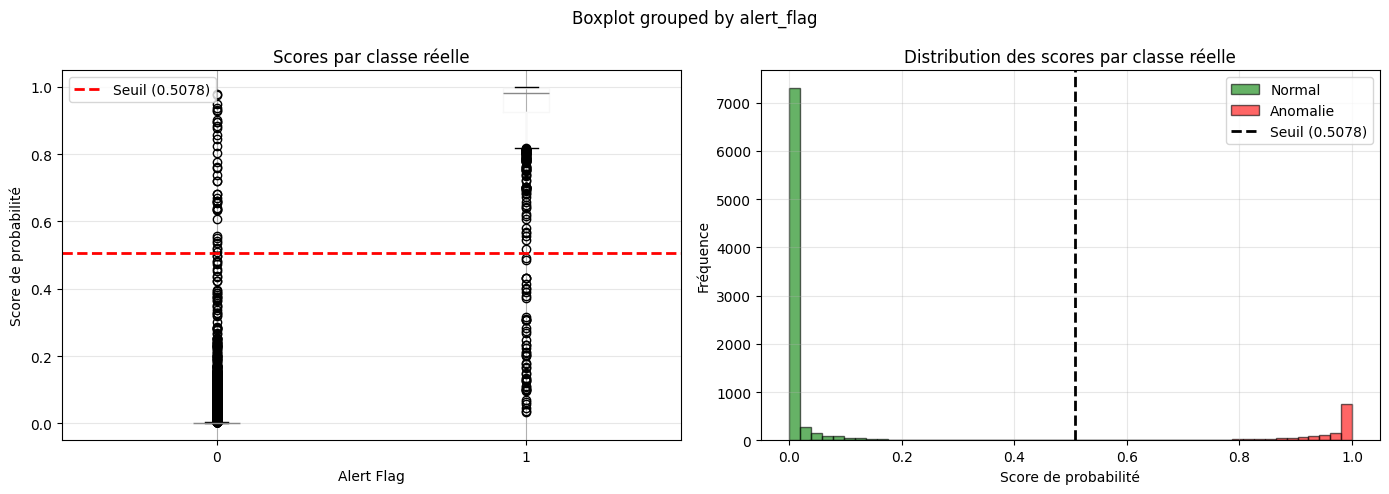

✅ Visualisations des scores par classe créées


In [43]:
# Visualisation des scores par classe réelle (si disponible)
if y_true is not None:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Boxplot par classe
    df_plot = pd.DataFrame({'score': scores, 'alert_flag': y_true})
    df_plot.boxplot(column='score', by='alert_flag', ax=axes[0])
    axes[0].axhline(tau, color='red', linestyle='--', linewidth=2, label=f'Seuil ({tau:.4f})')
    axes[0].set_xlabel('Alert Flag')
    axes[0].set_ylabel('Score de probabilité')
    axes[0].set_title('Scores par classe réelle')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Histogrammes superposés
    normal_scores = scores[y_true == 0]
    anomaly_scores = scores[y_true == 1]
    
    axes[1].hist(normal_scores, bins=50, alpha=0.6, label='Normal', color='green', edgecolor='black')
    axes[1].hist(anomaly_scores, bins=50, alpha=0.6, label='Anomalie', color='red', edgecolor='black')
    axes[1].axvline(tau, color='black', linestyle='--', linewidth=2, label=f'Seuil ({tau:.4f})')
    axes[1].set_xlabel('Score de probabilité')
    axes[1].set_ylabel('Fréquence')
    axes[1].set_title('Distribution des scores par classe réelle')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Visualisations des scores par classe créées")


## 11. Exemple de Prédiction sur un Nouvel Échantillon

Cette section montre comment faire une prédiction sur un nouvel échantillon individuel.


In [44]:
# Exemple: créer un nouvel échantillon
print("="*70)
print("EXEMPLE DE PREDICTION SUR UN NOUVEL ECHANTILLON")
print("="*70)

# Prendre un échantillon aléatoire comme exemple
sample_idx = np.random.choice(len(df_feat))
sample = df_feat.iloc[[sample_idx]].copy()

print(f"\n📋 Échantillon sélectionné (index {sample_idx}):")
print(f"  Patient ID: {sample['patient_id'].values[0]}")
print(f"\n  Features numériques:")
for col in num_cols[:5]:  # Afficher les 5 premières
    print(f"    {col}: {sample[col].values[0]:.4f}")

print(f"\n  Features catégorielles:")
for col in cat_cols:
    print(f"    {col}: {sample[col].values[0]}")

# Préparer les features
X_sample = sample[num_cols + cat_cols].copy()

# Appliquer le preprocessing
X_sample_prep = preprocessor.transform(X_sample)

# Prédiction
score_sample = classifier.predict_proba(X_sample_prep)[:, 1][0]
prediction_sample = (score_sample >= tau).astype(int)

print(f"\n🎯 Résultat de la prédiction:")
print(f"  Score de probabilité: {score_sample:.4f}")
print(f"  Prédiction: {'🔴 ANOMALIE' if prediction_sample == 1 else '🟢 NORMAL'}")
print(f"  Seuil utilisé: {tau:.4f}")

if "alert_flag" in df_raw.columns:
    true_label = df_raw.loc[sample.index[0], "alert_flag"]
    print(f"\n  Label réel: {'🔴 ANOMALIE' if true_label == 1 else '🟢 NORMAL'}")
    if prediction_sample == true_label:
        print(f"  ✅ Prédiction correcte!")
    else:
        print(f"  ❌ Prédiction incorrecte")


EXEMPLE DE PREDICTION SUR UN NOUVEL ECHANTILLON

📋 Échantillon sélectionné (index 7287):
  Patient ID: 152

  Features numériques:
    heart_rate_delta: 0.9429
    heart_rate_z: 0.2963
    hr_variability_delta: -4.0857
    hr_variability_z: -0.4978
    steps_delta: 2333.8571

  Features catégorielles:
    weekend: 1
    medication_taken: 0
    is_female: 1

🎯 Résultat de la prédiction:
  Score de probabilité: 0.0000
  Prédiction: 🟢 NORMAL
  Seuil utilisé: 0.5078

  Label réel: 🟢 NORMAL
  ✅ Prédiction correcte!
